In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

100% 722M/723M [00:43<00:00, 20.6MB/s]
100% 723M/723M [00:43<00:00, 17.6MB/s]


In [3]:
!unzip jigsaw-unintended-bias-in-toxicity-classification.zip

Archive:  jigsaw-unintended-bias-in-toxicity-classification.zip
  inflating: all_data.csv            
  inflating: identity_individual_annotations.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_private_expanded.csv  
  inflating: test_public_expanded.csv  
  inflating: toxicity_individual_annotations.csv  
  inflating: train.csv               


In [4]:
import pandas as pd

# Load the dataset
train_csv_path = "train.csv"
data = pd.read_csv(train_csv_path)

# Display the column names to verify the correct names
print(data.columns)

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')


In [6]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.3 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import joblib
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Example loading of your dataset
# data = pd.read_csv('path_to_your_dataset.csv')

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(data['comment_text'].fillna(''))  # Handle missing values in text

# Define the target variable and convert it to binary classification labels
threshold = 0.5  # Define any appropriate threshold if your target is continuous
y = (data['target'] >= threshold).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'gpu_hist',  # Utilize GPU optimized histogram method
        'predictor': 'gpu_predictor',  # Use GPU for prediction
        'scale_pos_weight': float(np.sum(y_train == 0) / np.sum(y_train == 1)),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# Train the final model with the best parameters
best_params = study.best_trial.params
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# Save the model and vectorizer
joblib.dump(final_model, 'best_xgboost_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

[I 2024-07-14 17:35:55,605] A new study created in memory with name: no-name-3934ab7e-5cdb-49ed-819c-2f70dce2fefc
[I 2024-07-14 17:37:41,323] Trial 0 finished with value: 0.6626476568384672 and parameters: {'max_depth': 8, 'learning_rate': 0.0015187460398474843, 'n_estimators': 655, 'min_child_weight': 3, 'gamma': 3.285468245209403, 'subsample': 0.6378941116099923, 'colsample_bytree': 0.6209733920972356}. Best is trial 0 with value: 0.6626476568384672.
[I 2024-07-14 17:38:52,673] Trial 1 finished with value: 0.6646007220047563 and parameters: {'max_depth': 5, 'learning_rate': 0.0012959177514805325, 'n_estimators': 632, 'min_child_weight': 6, 'gamma': 1.1451981696936475, 'subsample': 0.7838148907969915, 'colsample_bytree': 0.7053740735407188}. Best is trial 1 with value: 0.6646007220047563.
[I 2024-07-14 17:40:19,542] Trial 2 finished with value: 0.6822539004593076 and parameters: {'max_depth': 4, 'learning_rate': 0.07154668183866397, 'n_estimators': 950, 'min_child_weight': 3, 'gamma':

Number of finished trials: 100
Best trial: {'max_depth': 8, 'learning_rate': 0.04710183261752584, 'n_estimators': 885, 'min_child_weight': 8, 'gamma': 3.548906388801397, 'subsample': 0.583549335096797, 'colsample_bytree': 0.5464371870046401}


['tfidf_vectorizer.joblib']

ROC-AUC Score: 0.9234519340108625
Accuracy: 0.9441540272872082
Precision: 0.8099673316188225
Recall: 0.40074970768278423
F1 Score: 0.5362015414701484


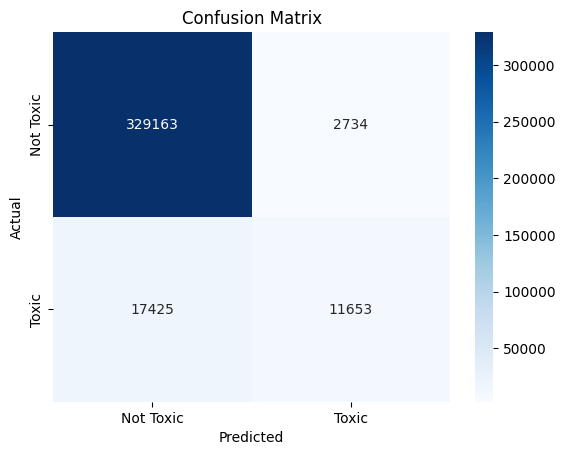

In [10]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities and use the probability of 1 for AUC calculation
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = final_model.predict(X_test)

# Calculate metrics
auc_score = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("ROC-AUC Score:", auc_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

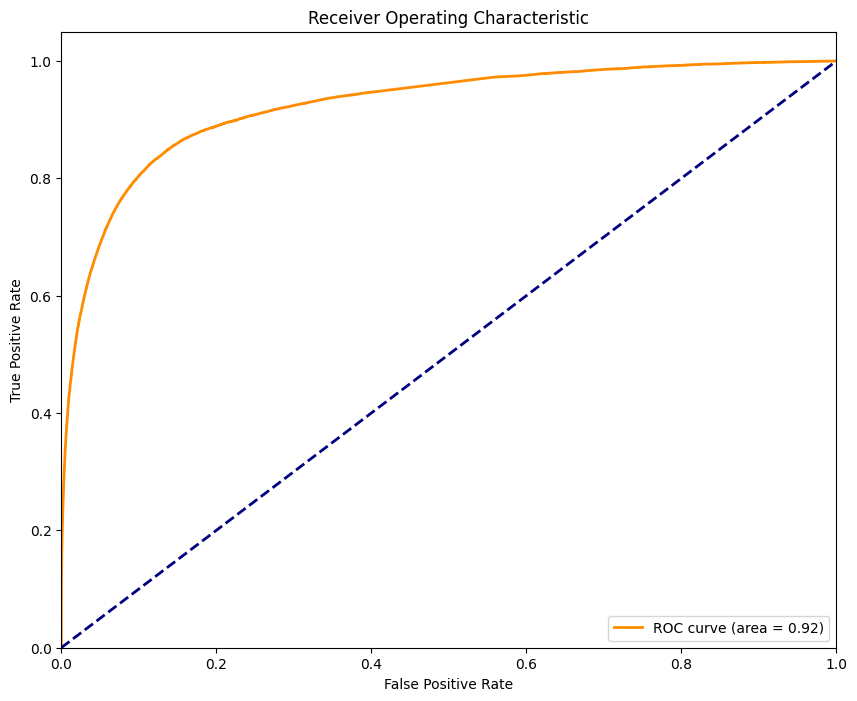

AUC: 0.92


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)  # Calculate the AUC

# Plotting the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Display the AUC
print("AUC: {:.2f}".format(roc_auc))


In [17]:
# Finding the optimal threshold
# This finds the threshold closest to the top-left corner of the ROC plot
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)

# Apply this threshold to classify comments
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# You can recalculate the performance metrics using this new threshold to see its impact
new_recall = recall_score(y_test, y_pred_optimal)
new_precision = precision_score(y_test, y_pred_optimal)
new_f1 = f1_score(y_test, y_pred_optimal)

print("New Recall:", new_recall)
print("New Precision:", new_precision)
print("New F1 Score:", new_f1)

Optimal Threshold: 0.05958188
New Recall: 0.8483389504092441
New Precision: 0.35233959892589845
New F1 Score: 0.49789080633767285


In [34]:
# Adjusting the threshold
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
threshold = 0.237
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Recalculate metrics with adjusted threshold
new_recall = recall_score(y_test, y_pred_adjusted)
new_precision = precision_score(y_test, y_pred_adjusted)
accuracy = accuracy_score(y_test, y_pred_adjusted)
new_f1 = f1_score(y_test, y_pred_adjusted)
print("Accuracy:", accuracy)
print("Adjusted Recall:", new_recall)
print("Adjusted Precision:", new_precision)
print("Adjusted F1 Score:", new_f1)

Accuracy: 0.940184223284161
Adjusted Recall: 0.6011073663938372
Adjusted Precision: 0.6362478159580663
Adjusted F1 Score: 0.6181786030061892
